In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib widget
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

In [3]:
root_dir = Path(r'H:\공유 드라이브\SWJ_works')
if not root_dir.exists():
    root_dir.mkdir()


In [4]:
data_dir = r'EPlus\SmallOffice_RefBuilding_EP9.3\Hourly_SCH\modified\Output_3Weathers'

In [5]:
csv_names = [
    'SmallOffice_ChicagoModel_5min_5AChicago_CapUnity.csv',
    'SmallOffice_ChicagoModel_5min_1AMiami_CapUnity.csv',
    'SmallOffice_ChicagoModel_5min_8Fairbanks_CapUnity.csv',
]


In [6]:
abb_dict = {
    'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)': 'Outdoor Air Drybulb Temperature [C]',
    'Environment:Site Outdoor Air Relative Humidity [%](TimeStep)': 'Outdoor Air Relative Humidity [%]',
    'Environment:Site Wind Speed [m/s](TimeStep)': 'Wind Speed [m/s]',
    'Environment:Site Wind Direction [deg](TimeStep)': 'Wind Direction [deg]',
    'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)': 'Diffuse Solar Radiation [W/m2]',
    'Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)': 'Direct Solar Radiation [W/m2]',
    'Environment:Site Day Type Index [](TimeStep)': 'Day Type Index',
    'ATTIC:Zone Air Temperature [C](TimeStep)': 'Attic temp [C]',
    'CORE_ZN:Zone Air Temperature [C](TimeStep)': 'Core zone temp [C]',
    'PERIMETER_ZN_1:Zone Air Temperature [C](TimeStep)': 'South zone temp [C]',
    'PERIMETER_ZN_2:Zone Air Temperature [C](TimeStep)': 'East zone temp [C]', 
    'PERIMETER_ZN_3:Zone Air Temperature [C](TimeStep)': 'North zone temp [C]', 
    'PERIMETER_ZN_4:Zone Air Temperature [C](TimeStep)': 'West zone temp [C]', 
    'BLDG_OCC_SCH:Schedule Value [](TimeStep)': 'Occupant sch',
    'BLDG_LIGHT_SCH:Schedule Value [](TimeStep)': 'Lighting sch',
    'BLDG_EQUIP_SCH:Schedule Value [](TimeStep)': 'Equipment sch',
    'BLDG_SWH_SCH:Schedule Value [](TimeStep)': 'Hot water sch', 
    'CLGSETP_SCH:Schedule Value [](TimeStep)': 'Cooling setpoint [C]',
    'HTGSETP_SCH:Schedule Value [](TimeStep)': 'Heating setpoint [C]',
    'CORE_ZN  IDEAL LOADS:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)': 'Core zone heating load [J]',
    'CORE_ZN  IDEAL LOADS:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)': 'Core zone cooling load [J]',
    'PERIMETER_ZN_1 IDEAL LOADS:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)': 'South zone heating load [J]',
    'PERIMETER_ZN_1 IDEAL LOADS:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)': 'South zone cooling load [J]',
    'PERIMETER_ZN_2  IDEAL LOADS:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)': 'East zone heating load [J]',
    'PERIMETER_ZN_2  IDEAL LOADS:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)': 'East zone cooling load [J]',
    'PERIMETER_ZN_3 IDEAL LOADS:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)': 'North zone heating load [J]',
    'PERIMETER_ZN_3 IDEAL LOADS:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)': 'North zone cooling load [J]',
    'PERIMETER_ZN_4 IDEAL LOADS:Zone Ideal Loads Zone Total Heating Energy [J](TimeStep)': 'West zone heating load [J]',
    'PERIMETER_ZN_4 IDEAL LOADS:Zone Ideal Loads Zone Total Cooling Energy [J](TimeStep)': 'West zone cooling load [J]',
    'DistrictHeating:Facility [J](TimeStep)': 'Total heating load [J]',
    'DistrictCooling:Facility [J](TimeStep) ': 'Total cooling load [J]',
}

In [7]:
bin = 30
stride = 30 // 5
time_length = 24 * 60 // bin
print(time_length)


training_dfs = [
    pd.read_csv(root_dir / data_dir / csv_names[i])
    .iloc[::stride]
    .reset_index(drop=True).rename(columns=abb_dict)
    for i in [0]
]

validation_dfs = [
    pd.read_csv(root_dir / data_dir / csv_names[i])
    .iloc[::stride]
    .reset_index(drop=True).rename(columns=abb_dict)
    for i in [1]
]

test_dfs = [
    pd.read_csv(root_dir / data_dir / csv_names[i])
    .iloc[::stride]
    .reset_index(drop=True).rename(columns=abb_dict)
    for i in [2]
]


48


In [8]:
training_dfs[0]

,Date/Time,Outdoor Air Drybulb Temperature [C],Outdoor Air Relative Humidity [%],Wind Speed [m/s],Wind Direction [deg],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],Day Type Index,Attic temp [C],Core zone temp [C],...,South zone heating load [J],South zone cooling load [J],East zone heating load [J],East zone cooling load [J],North zone heating load [J],North zone cooling load [J],West zone heating load [J],West zone cooling load [J],Total heating load [J],Total cooling load [J]
0,01/01 00:05:00,-2.575000,72.083333,2.600000,196.666667,0.0,0.0,1.0,-3.261999,15.6,...,285272.232897,0.0,264071.196346,0.0,414545.170436,0.0,288818.750111,0.0,1.459549e+06,0.0
1,01/01 00:35:00,-7.825000,72.583333,2.600000,236.666667,0.0,0.0,1.0,-4.335327,15.6,...,441223.578513,0.0,354289.837074,0.0,547105.310850,0.0,376592.360446,0.0,2.157041e+06,0.0
2,01/01 01:05:00,-12.158333,73.000000,2.600000,268.333333,0.0,0.0,1.0,-6.076190,15.6,...,571886.483903,0.0,431477.001019,0.0,661055.787028,0.0,451912.219835,0.0,2.747495e+06,0.0
3,01/01 01:35:00,-11.908333,73.000000,2.600000,258.333333,0.0,0.0,1.0,-7.523955,15.6,...,567578.819835,0.0,428516.431545,0.0,655270.431342,0.0,448769.131807,0.0,2.716423e+06,0.0
4,01/01 02:05:00,-11.650000,73.000000,2.558333,249.166667,0.0,0.0,1.0,-8.246870,15.6,...,561711.574731,0.0,424448.662680,0.0,647848.288163,0.0,444437.007829,0.0,2.680773e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12/31 21:35:00,-4.191667,81.000000,9.300000,250.000000,0.0,0.0,1.0,-2.131570,15.6,...,386101.194319,0.0,274198.679862,0.0,375435.728367,0.0,277458.064945,0.0,1.462587e+06,0.0
17516,12/31 22:05:00,-4.450000,80.750000,9.083333,251.666667,0.0,0.0,1.0,-2.549197,15.6,...,396986.158459,0.0,280589.076107,0.0,384488.085549,0.0,283691.227272,0.0,1.513260e+06,0.0
17517,12/31 22:35:00,-4.750000,79.250000,7.783333,261.666667,0.0,0.0,1.0,-2.910087,15.6,...,405432.067174,0.0,286326.533049,0.0,392621.150446,0.0,288659.721280,0.0,1.560872e+06,0.0
17518,12/31 23:05:00,-5.091667,78.250000,6.741667,269.166667,0.0,0.0,1.0,-3.266642,15.6,...,415158.140016,0.0,292811.509038,0.0,402011.046070,0.0,294405.754149,0.0,1.612524e+06,0.0


<AxesSubplot:>

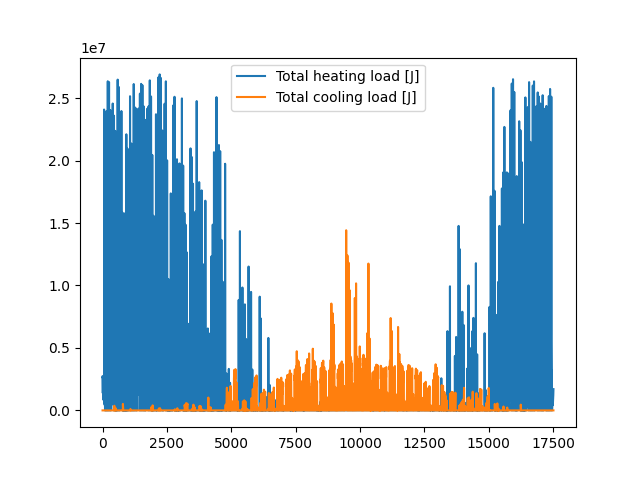

In [9]:
fig, ax = plt.subplots(facecolor='white')
training_dfs[0].plot(y= 'Total heating load [J]', ax=ax)
training_dfs[0].plot(y= 'Total cooling load [J]', ax=ax)
# fig.show()

In [10]:
from deep_time_series.util import merge_data_frames

In [11]:
training_df = merge_data_frames(training_dfs)
validation_df = merge_data_frames(validation_dfs)
test_df = merge_data_frames(test_dfs)


In [12]:
from deep_time_series.data import (
    TimeSeriesDataset,
    FeatureTransformers,
)

In [13]:
import torch.nn as nn
from deep_time_series.model import (
    MultiStepTransformer,
    RNN,
    MLP,
    DilatedCNN,
)
from deep_time_series.loss import DictLoss

In [14]:
target_names = [
    'Core zone heating load [J]',
    'Core zone cooling load [J]',
    'South zone heating load [J]',
    'South zone cooling load [J]',
    'East zone heating load [J]',
    'East zone cooling load [J]',
    'North zone heating load [J]',
    'North zone cooling load [J]',
    'West zone heating load [J]',
    'West zone cooling load [J]',
    # 'Total heating load [J]',
    # 'Total cooling load [J]',
    'Core zone temp [C]',
    'South zone temp [C]',
    'East zone temp [C]',
    'North zone temp [C]',
    'West zone temp [C]',
    'Attic temp [C]',
]

covariate_names = [
    'Outdoor Air Drybulb Temperature [C]',
    'Outdoor Air Relative Humidity [%]',
    'Wind Speed [m/s]',
    'Wind Direction [deg]',
    'Diffuse Solar Radiation [W/m2]',
    'Direct Solar Radiation [W/m2]',
    'Cooling setpoint [C]',
    'Heating setpoint [C]',
    # 'Day Type Index',
]

In [16]:
loss_fn = DictLoss(
    loss_dict={
        'label.targets': nn.MSELoss(),
    },
)

class Head(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 15)
        self.activation = nn.Softplus()

    def forward(self, x):
        # B x L x F.
        x = self.linear(x)
        x1 = self.activation(x[:, :, :10])

        x = torch.cat([
            x1, x[:, :, 10:]
        ], dim=2)

        return x


head = Head(in_features=128)

# head = nn.Sequential(
#     nn.Linear(128, len(target_names)),
#     nn.ReLU(),
# )

# head = None

# model = MultiStepTransformer(
#     n_encoder_features=len(target_names)+len(covariate_names),
#     n_decoder_features=len(covariate_names),
#     d_model=64,
#     n_heads=4,
#     n_layers=2,
#     dim_feedforward=128,
#     n_outputs=len(target_names),
#     lr=1e-4,
#     dropout_rate=0.1,
#     loss_fn=loss_fn,
# )

model = RNN(
    n_features=len(target_names)+len(covariate_names),
    hidden_size=128,
    n_layers=2,
    n_outputs=len(target_names),
    rnn_class=nn.GRU,
    dropout_rate=0.0,
    lr=1e-4,
    loss_fn=loss_fn,
    teacher_forcing=False,
    head=head,
)

# model = MLP(
#     n_features=len(target_names)+len(covariate_names),
#     hidden_size=64,
#     encoding_length=24,
#     n_hidden_layers=3,
#     n_outputs=len(target_names),
#     activation=nn.ELU(),
#     lr=1e-4,
#     loss_fn=loss_fn,
# )

In [17]:
chunk_specs = model.make_chunk_specs(target_names, covariate_names)

feature_transformers = FeatureTransformers(
    transformer_dict={
        # k: StandardScaler() for k in target_names + covariate_names
        k: MinMaxScaler() for k in target_names + covariate_names
    },
)

training_dataset = TimeSeriesDataset(
    df=training_df,
    encoding_length=time_length,
    decoding_length=time_length,
    chunk_specs=chunk_specs,
    feature_transformers=feature_transformers,
)

validation_dataset = TimeSeriesDataset(
    df=validation_df,
    encoding_length=time_length,
    decoding_length=time_length,
    chunk_specs=chunk_specs,
    feature_transformers=training_dataset.feature_transformers,
    fit_feature_transformers=False,
)

training_data_loader = DataLoader(
    training_dataset, batch_size=64, shuffle=True, num_workers=0
)

validation_data_loader = DataLoader(
    validation_dataset, batch_size=64, num_workers=0
)

test_dataset = TimeSeriesDataset(
    df=test_df,
    encoding_length=time_length,
    decoding_length=time_length,
    chunk_specs=chunk_specs,
    feature_transformers=feature_transformers,
    fit_feature_transformers=False,
    return_time_index=True,
)

test_data_loader = DataLoader(
    test_dataset, batch_size=time_length, shuffle=False, num_workers=0
)


In [18]:
from datetime import datetime
date_time = datetime.now().strftime("%m.%d.%Y-%H.%M.%S")

tag = f'gru-load-test'
folder_name = tag + f'-{date_time}'

trainer = pl.Trainer(
    default_root_dir=root_dir / 'runs' / folder_name, 
    max_epochs=500,
    gpus=1,
    #auto_lr_find=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [19]:
trainer.fit(
    model=model,
    train_dataloaders=training_data_loader,
    val_dataloaders=validation_data_loader,
)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | encoder | GRU  | 157 K 
1 | head    | Head | 1.9 K 
---------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.637     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\BET_lab\anaconda3\envs\dts\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\BET_lab\anaconda3\envs\dts\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 393: 100%|██████████| 546/546 [00:24<00:00, 22.59it/s, loss=7.1e-05, v_num=0] 


In [20]:
DEVICE = 'cuda'

model = RNN.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    # r"H:\공유 드라이브\SWJ_works\runs\gru-load-test-02.22.2022-21.44.07\lightning_logs\version_0\checkpoints\epoch=188-step=51596.ckpt",
    map_location=DEVICE,
)

In [21]:
model.eval().to('cuda')

real_traces = []
pred_traces = []
for i, samples in enumerate(test_data_loader):
    samples = {k: v[:1].cuda() for k, v in samples.items()}
    real = samples['label.targets'][0].cpu().numpy()

    # if i != 0:
    #     samples['encoding.targets'] = outputs['label.targets']

    with torch.no_grad():
        outputs = model(samples)

    pred = outputs['label.targets'][0].cpu().numpy()

    real_traces.append(real)
    pred_traces.append(pred)

In [22]:
real_history = np.concatenate(real_traces, axis=0)
pred_history = np.concatenate(pred_traces, axis=0)

real_df = test_dataset.convert_item_to_df(
    {'label.targets': real_history}
)['label.targets']

pred_df = test_dataset.convert_item_to_df(
    {'label.targets': pred_history}
)['label.targets']

print(np.abs(real_df - pred_df).mean())

Core zone heating load [J]     86734.257812
Core zone cooling load [J]     17858.951172
South zone heating load [J]    86860.125000
South zone cooling load [J]    38798.125000
East zone heating load [J]     49474.882812
East zone cooling load [J]     16092.763672
North zone heating load [J]    70345.320312
North zone cooling load [J]    10076.978516
West zone heating load [J]     45009.199219
West zone cooling load [J]      7191.993652
Core zone temp [C]                 0.231270
South zone temp [C]                0.340560
East zone temp [C]                 0.262857
North zone temp [C]                0.215485
West zone temp [C]                 0.225334
dtype: float32


In [23]:
import ipywidgets as widgets

interactive(children=(Dropdown(description='name', options=('Core zone heating load [J]', 'Core zone cooling l…

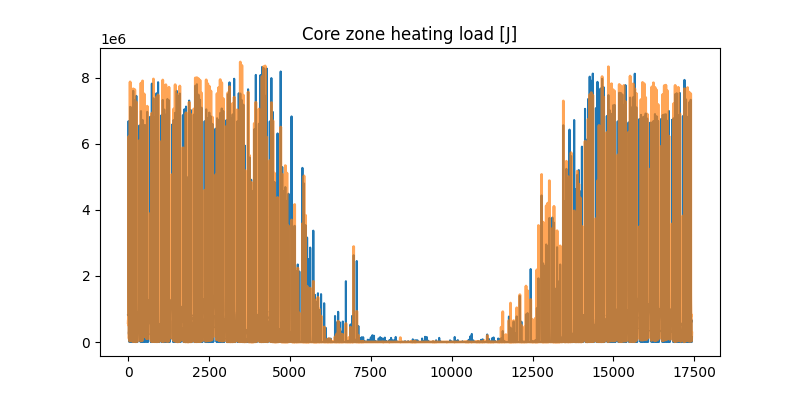

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))

@widgets.interact(name=target_names)
def update(name):
    # i = target_names.index(name)
    ax.clear()
    ax.set_title(name)
    ax.plot(real_df[name], label='real')
    ax.plot(pred_df[name], label='pred', alpha=0.7, lw=2)

interactive(children=(Dropdown(description='name', options=('Core zone heating load [J]', 'Core zone cooling l…

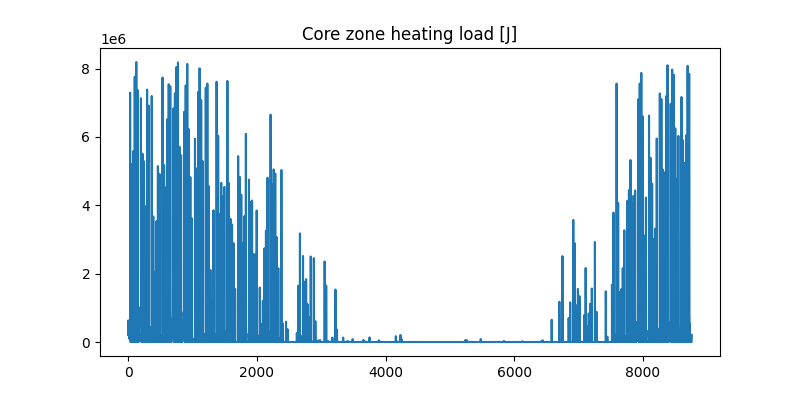

In [71]:
fig2, ax2 = plt.subplots(figsize=(8, 4))

@widgets.interact(name=target_names)
def update(name):
    # i = target_names.index(name)
    ax2.clear()
    ax2.set_title(name)
    ax2.plot(training_dfs[0][name], label='real')